# Bayesian Exploration with NaNs

As violations of constraints can lead to invalid values of the objective, the evaluate function may simply return NaNs. We demonstrate below how we can still perform Bayesian Exploration in that case.

In [1]:
# set values if testing
import os
SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_MC_SAMPLES = 1 if SMOKE_TEST else 128
NUM_RESTARTS = 1 if SMOKE_TEST else 20

# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import torch
import yaml
from copy import deepcopy
from xopt import Xopt, Evaluator
from xopt.generators.bayesian import BayesianExplorationGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs

vocs = deepcopy(tnk_vocs)
vocs.objectives = {}
vocs.observables = ["y1"]

In [2]:
# modify the evaluate function to return NaNs if constraints are violated
def evaluate(input_dict):
    output_dict = evaluate_TNK(input_dict)
    del output_dict["y2"]
    for c in vocs.constraints.keys():
        if vocs.constraints[c][0].upper() == "GREATER_THAN" and output_dict[c] <= vocs.constraints[c][1]:
            output_dict["y1"] = torch.nan
        elif vocs.constraints[c][0].upper() == "LESS_THAN" and output_dict[c] >= vocs.constraints[c][1]:
            output_dict["y1"] = torch.nan
    return output_dict

In [3]:
generator = BayesianExplorationGenerator(vocs=vocs)
generator.max_travel_distances = [0.25, 0.25]
generator.n_monte_carlo_samples = NUM_MC_SAMPLES
generator.numerical_optimizer.n_restarts = NUM_RESTARTS

evaluator = Evaluator(function=evaluate)
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X


            Xopt
________________________________
Version: 0+untagged.1.g8978f87
Data size: 0
Config as YAML:
dump_file: null
evaluator:
  function: __main__.evaluate
  function_kwargs: {}
  max_workers: 1
  vectorized: false
generator:
  computation_time: null
  fixed_features: null
  gp_constructor:
    covar_modules: {}
    custom_noise_prior: null
    mean_modules: {}
    name: standard
    trainable_mean_keys: []
    transform_inputs: true
    use_low_noise_prior: true
  log_transform_acquisition_function: false
  max_travel_distances:
  - 0.25
  - 0.25
  model: null
  n_candidates: 1
  n_interpolate_points: null
  n_monte_carlo_samples: 128
  name: bayesian_exploration
  numerical_optimizer:
    max_iter: 2000
    max_time: null
    n_restarts: 20
    name: LBFGS
  supports_batch_generation: true
  turbo_controller: null
  use_cuda: false
max_evaluations: null
serialize_inline: false
serialize_torch: false
strict: true
vocs:
  constants:
    a: dummy_constant
  constraints:
    

## Run exploration
We start with evaluating 2 points that we know satisfy the constraints. We then run
30 exploration steps.

In [4]:
X.evaluate_data(pd.DataFrame({"x1": [1.0, 0.75], "x2": [0.7, 0.95]}))

,x1,x2,a,y1,c1,c2,xopt_runtime,xopt_error
0,1.00,0.70,dummy_constant,1.00,0.584045,0.290,0.000054,False
1,0.75,0.95,dummy_constant,0.75,0.494833,0.265,0.000018,False


In [5]:
N_STEPS = 1 if SMOKE_TEST else 30
for i in range(N_STEPS):
    print(f"step {i}")
    X.step()

step 0


step 1


step 2


step 3


step 4


step 5


step 6


step 7


step 8


step 9


step 10


step 11


step 12


step 13


step 14


step 15


step 16


step 17


step 18


step 19


step 20


step 21


step 22


step 23


step 24


step 25


step 26


step 27


step 28


step 29


In [6]:
# view the data
X.data

,x1,x2,a,y1,c1,c2,xopt_runtime,xopt_error
0,1.000000,0.700000,dummy_constant,1.000000,0.584045,0.290000,0.000054,False
1,0.750000,0.950000,dummy_constant,0.750000,0.494833,0.265000,0.000018,False
2,1.535397,1.735397,dummy_constant,NaN,4.313110,2.598255,0.000032,False
3,2.320795,0.950000,dummy_constant,NaN,5.188811,3.517794,0.000028,False
4,1.790046,0.164602,dummy_constant,NaN,2.221010,1.776709,0.000029,False
5,1.004648,0.000000,dummy_constant,NaN,-0.090682,0.504670,0.000027,False
6,0.219251,0.773192,dummy_constant,NaN,-0.325374,0.153454,0.000031,False
7,0.000000,1.558590,dummy_constant,NaN,1.329202,1.370612,0.000030,False
8,0.402725,1.060374,dummy_constant,0.402725,0.197684,0.323482,0.000034,False
9,1.055075,0.327093,dummy_constant,1.055075,0.210432,0.338005,0.000029,False


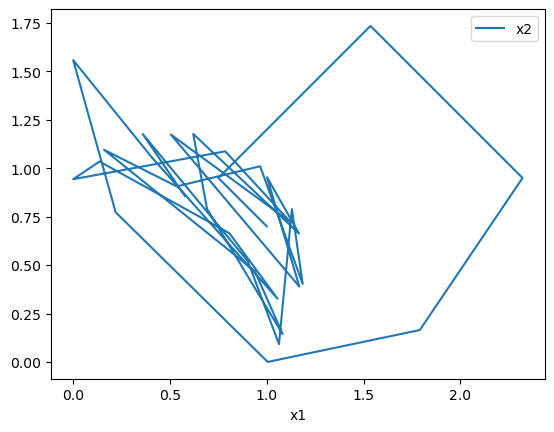

In [7]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")